# Physical simulation of the polyester rope mounting structure

This file contains a simulation of an idealized model of the polyester rope mounting structure to be used to mount the 8seg display. The rope is simulated as ideal elastic hooke springs using parameters from a rope manufacturer's website, and care is taken to keep all ropes below ~20% their breaking strength to keep reality close enough to the model. For simplicity mass is simply simulated by every knot/node having a certain mass.

In [1]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib notebook

### Global parameters

In [2]:
g = 9.81  # earth gravity constant [m/s^2]
m = 10/146 # node mass [kg]
e = 2  # initial distance between the masses
l = 1.5  # relaxed length of the springs

# data for 3mm cord
mbreak = 298 # [kg]
elongation_20percent_break = 0.03 # [1]

Fbreak = mbreak * g
stiffness_3mm = (Fbreak*0.2) / elongation_20percent_break  # spring stiffness

# data for 4mm cord
mbreak = 490 # [kg]
elongation_20percent_break = 0.03 # [1]

Fbreak = mbreak * g
stiffness_4mm = (Fbreak*0.2) / elongation_20percent_break  # spring stiffness

stiffness_thick = stiffness_4mm
stiffness_thin = stiffness_3mm

overall_width = 62 # [m]
parabola_height_top = 1.0 # [m]
parabola_height_bottom = parabola_height_top
digit_height = 2.0 # [m]
parabola_offset = 0.4 # [m]

anchor_offset_y_top = digit_height/2
anchor_offset_y_bottom = -digit_height/2
parabola_offset_y_top = anchor_offset_y_top + parabola_offset
parabola_offset_y_bottom = anchor_offset_y_bottom - parabola_offset

pad_digits = 5 # pad empty digits on each side
bracing_pad = 2
digits = 25 + pad_digits*2
points_top_parabola = digits + 2 # pad 2 for tree anchors
points_top_anchor = digits + 1 # pad 1 for off-by-one
points_bottom_parabola = points_top_parabola
points_bottom_anchor = points_top_anchor

### Node positions, overall layout

In [3]:

P_top_parabola = np.zeros((points_top_parabola, 2))
P_top_anchor = np.zeros((points_top_anchor, 2))

P_top_parabola[:,0] = np.linspace(-overall_width/2, overall_width/2, points_top_parabola)
parabola_coeff_top = parabola_height_top/((overall_width/2)**2)
P_top_parabola[:,1] = parabola_offset_y_top + parabola_coeff_top*(P_top_parabola[:,0]**2)

P_top_anchor[:,0] = np.linspace(-overall_width/2, overall_width/2, points_top_anchor)
P_top_anchor[:,1] = anchor_offset_y_top

P_bottom_parabola = np.zeros((points_bottom_parabola, 2))
P_bottom_anchor = np.zeros((points_bottom_anchor, 2))

P_bottom_parabola[:,0] = np.linspace(-overall_width/2, overall_width/2, points_bottom_parabola)
parabola_coeff_bottom = parabola_height_bottom/((overall_width/2)**2)
P_bottom_parabola[:,1] = parabola_offset_y_bottom - parabola_coeff_bottom*(P_bottom_parabola[:,0]**2)

P_bottom_anchor[:,0] = np.linspace(-overall_width/2, overall_width/2, points_bottom_anchor)
P_bottom_anchor[:,1] = anchor_offset_y_bottom

P0 = np.vstack([P_top_parabola, P_top_anchor, P_bottom_parabola, P_bottom_anchor])

#P0[:, 0] = np.repeat(e * np.arange(n // 2), 2)
#P0[:, 1] = np.tile((0, -e), n // 2)
#P0[-2:, 1] = [-0.5, -0.5-e]
n = len(P0)

### Some scaling parameters to put tension on the ropes

In [17]:
anchor_xbrance_len = 0.99
par_len_top = 0.98
par_len_bottom = 0.98
anchor_len = 0.98
xbrace_len = 0.96
overall_len_factor = 1.01

### Connectivity matrix A, edge length matrix L and stiffness matrix K

Since this system is rather simple, we're simply using sparse connectivity matrices for everything holding two elements for every node pair.

1.7058364644977657 (36,) (37, 37)
1.75336 (35,) (36, 36)
1.1141728717151573 (62,) (36, 36)
1.7058364644977657 (36,) (37, 37)
1.75336 (35,) (36, 36)
1.1141728717151573 (62,) (36, 36)
2.671428768134445 (62,) (36, 36)


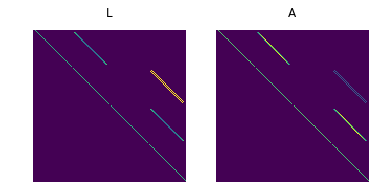

In [18]:
p = bracing_pad

A = np.zeros((n, n))
#np.eye(n, n, 1) + np.eye(n, n, 2)
i, j = points_top_parabola, points_top_parabola+points_top_anchor
k, l = j+points_bottom_parabola, j+points_bottom_parabola+points_bottom_anchor

## Top
# parabola
A[:i, :i] = np.eye(points_top_parabola, points_top_parabola, 1)# * par_len_top
# anchor
A[i:j, i:j] = np.eye(points_top_anchor, points_top_anchor, 1)# * anchor_len
# cross-bracing
A[1+p:i-p, i+p:j-p] = np.eye(points_top_anchor-2*p, points_top_anchor-2*p, 0)# * xbrace_len
A[1+p:i-p, i+p:j-p] += np.eye(points_top_anchor-2*p, points_top_anchor-2*p, 1)# * xbrace_len
A[i-1-p, j-1-p] = 0

## Bottom
# parabola
A[j:k, j:k] = np.eye(points_bottom_parabola, points_bottom_parabola, 1)# * par_len_bottom
# anchor
A[k:l, k:l] = np.eye(points_bottom_anchor, points_bottom_anchor, 1)# * anchor_len
# cross-bracing
A[j+1+p:k-p, k+p:l-p] = np.eye(points_bottom_anchor-2*p, points_bottom_anchor-2*p, 0)# * xbrace_len
A[j+1+p:k-p, k+p:l-p] += np.eye(points_bottom_anchor-2*p, points_bottom_anchor-2*p, 1)# * xbrace_len
A[k-1-p, l-1-p] = 0

# Anchor cross-bracing
A[i+p:j-p, k+p:l-p] = np.eye(points_top_anchor-2*p, points_top_anchor-2*p, 1)# * anchor_xbrance_len
A[i+p:j-p, k+p:l-p] += np.eye(points_top_anchor-2*p, points_top_anchor-2*p, -1)# * anchor_xbrance_len


#L = l * (np.eye(n, n, 1) + np.eye(n, n, 2))
#for i in range(n // 2 - 1):
#    L[2 * i + 1, 2 * i + 2] *= np.sqrt(2)

def spring_length(i, j):
    return np.sqrt((P0[i,0]-P0[j,0])**2 +
                   (P0[i,1]-P0[j,1])**2)
L = np.zeros((n, n))
#np.eye(n, n, 1) + np.eye(n, n, 2)

for _i in range(n):
    for _j in range(n):
        L[_i, _j] = spring_length(_i, _j) * A[_i, _j]

L[:i, :i] *= par_len_top * overall_len_factor
L[i:j, i:j] *= anchor_len * overall_len_factor
L[1:i, i:j] *= xbrace_len * overall_len_factor
L[j:k, j:k] *= par_len_bottom * overall_len_factor
L[k:l, k:l] *= anchor_len * overall_len_factor
L[j+1:k, k:l] *= xbrace_len * overall_len_factor
L[i:j, k:l] *= anchor_xbrance_len * overall_len_factor

K = np.zeros((n, n))
K[:i, :i] = stiffness_thick # parabola top
K[i:j, i:j] = stiffness_thick # anchor top
K[1:i, i:j] = stiffness_thin # cross-bracing top parabola to anchor
K[j:k, j:k] = stiffness_thick # parabola bottom
K[k:l, k:l] = stiffness_thick # anchor bottom
K[j+1:k, k:l] = stiffness_thin # cross-bracing bottom parabola to anchor
K[i:j, k:l] = stiffness_thin # anchor cross-bracing


A = np.array([[k/l if l>0 else 0 for k, l in zip(ks, ls)] for ks, ls in zip(K, L)])

#L[:i, :i] = np.eye(points_top_parabola, points_top_parabola, 1)
#L[i:j, i:j] = np.eye(points_top_anchor, points_top_anchor, 1) * 0.5
# cross-bracing
#L[1:i, i:] = np.eye(points_top_anchor, points_top_anchor, 0) * 1.4142
#L[1:i, i:] += np.eye(points_top_anchor, points_top_anchor, 1) * 1.4142
#L[i-1, j-1] = 0

# We display a graphic representation of
# the matrix.
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.matshow(L)
ax1.set_axis_off()
ax1.set_title('L')
ax2.matshow(A)
ax2.set_axis_off()
ax2.set_title('A')

for le_slice in [(slice(0,i), slice(0,i)), (slice(i,j), slice(i,j)), (slice(1,i), slice(i,j)),
                 (slice(j,k), slice(j,k)), (slice(k,l), slice(k,l)), (slice(j+1,k), slice(k,l)),
                 (slice(i,j), slice(k,l))]:
    frob = L[le_slice]
    print(frob[frob != 0].mean(), frob[frob != 0].shape, frob.shape)

### Result plotting infrastructure

We're using my blog's nice colorscheme here, and using a hand-tweaked somewhat colorblindness-friendly colormap for edge colors that's still looking fairly nice in the overall colorscheme.

In [5]:
I, J = np.nonzero(A)

In [6]:
def dist(P):
    return np.sqrt((P[:,0]-P[:,0][:,np.newaxis])**2 +
                   (P[:,1]-P[:,1][:,np.newaxis])**2)

In [7]:
cmap_pos = mpl.colors.LinearSegmentedColormap('energy_pos', {
    'red': ((0., 0xfe/255, 0xfe/255), (1., 1., 1.)),
    'green': ((0., 0x3e/255, 0x3e/255), (1., .9, .9)),
    'blue': ((0., 0xa0/255, 0xa0/255), (1., 0., 0.))
}).reversed()
cmap_neg = mpl.colors.LinearSegmentedColormap('energy_neg', {
    'red': ((0., 0x08/255, 0x08/255), (1., 0., 0.)),
    'green': ((0., 0xbd/255, 0xbd/255), (1., 1., 1.)),
    'blue': ((0., 0xf9/255, 0xf9/255), (1., .5, .5))
}).reversed()
#cmap_neg = mpl.colors.LinearSegmentedColormap('energy_neg', {
#    'red': ((0., 0x01/255, 0x01/255), (1., 0., 0.)),
#    'green': ((0., 0x76/255, 0x76/255), (1., 1., 1.)),
#    'blue': ((0., 0x9D/255, 0x9D/255), (1., .5, .5))
#})

def show_bar(P, title='No title'):
    fig, ax = plt.subplots(1, 1, figsize=(9, 4.5))

    # Wall.
    #ax.axvline(0, color='k', lw=3)

    # Distance matrix.
    D = dist(P)

    # Get normalized elongation in [-1, 1].
    elong = np.array([D[i, j] - L[i, j]
                      for i, j in zip(I, J)])
    elong_max = elong.max()
    elong_min = elong.min()
    
    A_foo = np.array([A[i, j]
                      for i, j in zip(I, J)])
    a_max = A_foo[elong.argmax()]
    
    force = A_foo * elong
    force_max = force.max()
    force_min = force.min()

    # The color depends on the spring tension, which
    # is proportional to the spring elongation.
    colors = np.zeros((len(elong), 4))
    colors[:, -1] = 1  # alpha channel is 1

    # Use two different sequentials colormaps for
    # positive and negative elongations, to show
    # compression and extension in different colors.
    pos, neg = elong > 0, elong < 0
    colors[pos] = cmap_pos(force[pos]/force_max)
    colors[neg] = cmap_neg(elong[neg]/elong_min)

    # We plot the springs.
    for i, j, c, is_pos in zip(I, J, colors, pos):
        if is_pos:
            ax.plot(P[[i, j], 0], P[[i, j], 1], lw=2, color=c)
        else:
            ax.plot(P[[i, j], 0], P[[i, j], 1], lw=1, color=c)

    edge_count = ((A + A.T) != 0).sum(axis=0)
    single_edge = np.where(edge_count == 1)
    not_single_edge = np.where(edge_count != 1)
    
    # We plot the masses.
    ax.plot(P[not_single_edge, 0], P[not_single_edge, 1], marker='.', color='#fe3ea0')
    ax.plot(P[single_edge, 0], P[single_edge, 1], marker='s', markersize=6, color='#fe3ea0')

    # We configure the axes.
    # Use non-equal scaling factors for x and y to improve readability since our structure is highly elongated.
    #ax.axis('equal')
    ax.set_xlim(P[:, 0].min() - e,
                P[:, 0].max() + e)
    ax.set_ylim(P[:, 1].min() - e/4,
                P[:, 1].max() + e/4)
    ax.grid()
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    
    cax1, _ = mpl.colorbar.make_axes(plt.gca(), fraction=0.05, pad=0.1)
    cbar = mpl.colorbar.ColorbarBase(cax1, cmap=cmap_pos, norm=mpl.colors.Normalize(vmin=0, vmax=force_max/g),
                                     label='Force [kg equiv., thick lines]')
    cax1.yaxis.set_ticks_position('left')
    cax1.yaxis.set_label_position('left')
    cax2, _ = mpl.colorbar.make_axes(plt.gca(), fraction=0.475)
    cbar = mpl.colorbar.ColorbarBase(cax2, cmap=cmap_neg, norm=mpl.colors.Normalize(vmin=0, vmax=-elong_min*100),
                                     label='Slack [cm, thin lines]')

    for iax in (ax, cax1, cax2):
        iax.spines['top'].set_visible(False)
        iax.spines['right'].set_visible(False)
        iax.spines['bottom'].set_color('#08bdf9')
        iax.spines['left'].set_color('#08bdf9')
        iax.tick_params(axis='x', colors='#01769D')
        iax.tick_params(axis='y', colors='#01769D')
        iax.xaxis.label.set_color('#01769D')
        iax.yaxis.label.set_color('#01769D')
        iax.grid(color='#08bdf9', linestyle=':')
    
    title = f'{title}, $F_{{max}} = {a_max*elong_max:.3g}[N] \equiv {a_max*elong_max/g:.3g} [kg]$'
    ax.title.set_color('#01769D')
    ax.set_title(title)
    
    return fig

### Plot initial setup before simulation

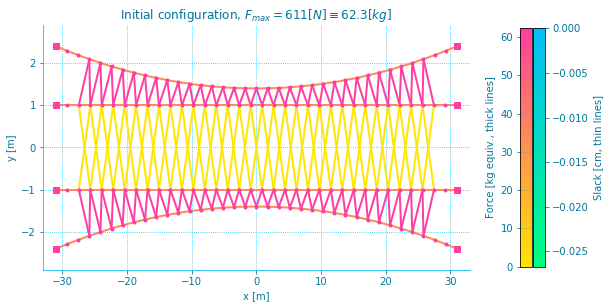

In [8]:
fig = show_bar(P0, title='Initial configuration')
fig.savefig('/tmp/initial_plot.svg')

### Energy function for optimizer

In [9]:
def energy(P):
    # The argument P is a vector (flattened matrix).
    # We convert it to a matrix here.
    P = P.reshape((-1, 2))
    # We compute the distance matrix.
    D = dist(P)
    
    delta_x = D - L
    #delta_x[L!=0] /= L[L!=0]
    delta_x = np.clip(delta_x, 0, None)
    #fig, ax = plt.subplots()
    #ax.imshow(A * delta_x)
    
    # The potential energy is the sum of the
    # gravitational and elastic potential energies.
    return (g * m * P[:, 1].sum() +
            .5 * (A * delta_x**2).sum())

In [10]:
energy(P0.ravel())

1741.2731117646306

### Bounds for optimizer

The layout of this data structure is a bit funky with min/maxes separately for every coordinate. See the L-BFGS-B scipy opt doc for reference.

In [11]:
#bounds = np.c_[P0[:2, :].ravel(),
#               P0[:2, :].ravel()].tolist() + \
#    [[None, None]] * (2 * (n - 4)) + \
#    np.c_[P0[-2:, :].ravel(),
#               P0[-2:, :].ravel()].tolist()


bounds = np.array([[None, None]] * n*2)

In [12]:
i, j = points_top_parabola, points_top_parabola+points_top_anchor
k, l = j+points_bottom_parabola, j+points_bottom_parabola+points_bottom_anchor
par_y_top = anchor_offset_y_top + parabola_offset_y_top + parabola_height_top

bounds[0, :] = [-overall_width/2, -overall_width/2] # parabola left x
bounds[1, :] = [par_y_top, par_y_top] # parabola left y
bounds[2*i-2, :] = [overall_width/2, overall_width/2] # parabola right x
bounds[2*i-1, :] = [par_y_top, par_y_top] # parabola right y
bounds[2*i, :] = [-overall_width/2, -overall_width/2] # anchor left x
bounds[2*i+1, :] = [anchor_offset_y_top, anchor_offset_y_top] # anchor left y
bounds[2*j-2, :] = [overall_width/2, overall_width/2] # anchor right x
bounds[2*j-1, :] = [anchor_offset_y_top, anchor_offset_y_top] # anchor right y

In [13]:
i, j = points_top_parabola, points_top_parabola+points_top_anchor
k, l = j+points_bottom_parabola, j+points_bottom_parabola+points_bottom_anchor
par_y_bottom = anchor_offset_y_bottom + parabola_offset_y_bottom - parabola_height_bottom

bounds[2*j+0, :] = [-overall_width/2, -overall_width/2] # parabola left x
bounds[2*j+1, :] = [par_y_bottom, par_y_bottom] # parabola left y
bounds[2*k-2, :] = [overall_width/2, overall_width/2] # parabola right x
bounds[2*k-1, :] = [par_y_bottom, par_y_bottom] # parabola right y
bounds[2*k, :] = [-overall_width/2, -overall_width/2] # anchor left x
bounds[2*k+1, :] = [anchor_offset_y_bottom, anchor_offset_y_bottom] # anchor left y
bounds[2*l-2, :] = [overall_width/2, overall_width/2] # anchor right x
bounds[2*l-1, :] = [anchor_offset_y_bottom, anchor_offset_y_bottom] # anchor right y

### Run optimizer

In [14]:
P1 = opt.minimize(energy, P0.ravel(),
                  method='L-BFGS-B',
                  options=dict(maxfun=100000, maxiter=100000, maxls=100, gtol=1e-6),
                  bounds=bounds).x.reshape((-1, 2))

### Render result

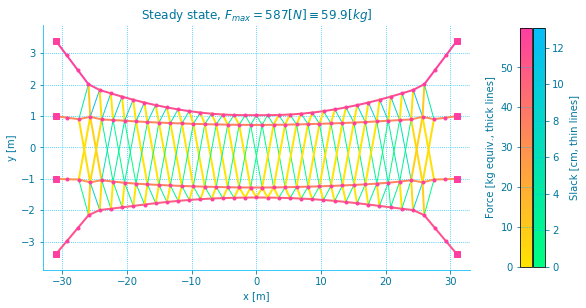

In [15]:
fig = show_bar(P1, title='Steady state')
fig.savefig('/tmp/optimized_plot.svg')

### Plot node displacements

This computes and plots
1. The distance of top and bottom nodes of the digit holding lines. To much error here would lead to the digit's vertical and diagonal segments not being taut or getting overly stressed and torn apart.
2. The overall (common) droop of top and bottom digit holding lines. This will simply be visible as the display banner drooping down in the middle.

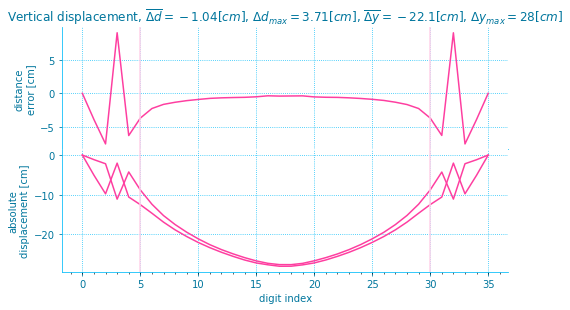

In [16]:
i, j = points_top_parabola, points_top_parabola+points_top_anchor
k, l = j+points_bottom_parabola, j+points_bottom_parabola+points_bottom_anchor
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4.5), sharex=True)
fig.subplots_adjust(hspace=0)
dist_err = -(P1[k:l] - P1[i:j])[:,1] - digit_height
ax1.plot(dist_err*100, color='#fe3ea0')
ax1.set_ylabel('distance\nerror [cm]')
abs_disp_bot = (P1[k:l]-anchor_offset_y_bottom)[:,1]
abs_disp_top = (P1[i:j]-anchor_offset_y_top)[:,1]
ax2.plot(abs_disp_bot*100, color='#fe3ea0')
ax2.plot(abs_disp_top*100, color='#fe3ea0')
ax2.set_ylabel('absolute\ndisplacement [cm]')
ax1.grid(), ax2.grid()
ax2.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax2.set_xlabel('digit index')

for ax in (ax1, ax2):
    ax.axvline(pad_digits, color='#ffd2e9')
    ax.axvline(digits-pad_digits, color='#ffd2e9')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('#08bdf9')
    ax.spines['left'].set_color('#08bdf9')
    ax.tick_params(axis='x', colors='#01769D')
    ax.tick_params(axis='y', colors='#01769D')
    ax.xaxis.label.set_color('#01769D')
    ax.yaxis.label.set_color('#01769D')
    ax.grid(color='#08bdf9', linestyle=':')

display_part = slice(pad_digits, -pad_digits-1)
dist_err_mean, dist_err_max = dist_err[display_part].mean(), np.abs(dist_err[display_part]).max()
abs_disps = np.vstack([abs_disp_bot[display_part], abs_disp_top[display_part]])
abs_disp_mean, abs_disp_max = abs_disps.mean(), np.abs(abs_disps).max()
ax1.set_title(f'Vertical displacement, $\overline{{\Delta d}}={dist_err_mean*100:.3g}[cm]$, $\Delta d_{{max}}={dist_err_max*100:.3g}[cm]$, $\overline{{\Delta y}}={abs_disp_mean*100:.3g}[cm]$, $\Delta y_{{max}}={abs_disp_max*100:.3g}[cm]$')
ax1.title.set_color('#01769D')
fig.savefig('/tmp/displacement_plot.svg')